<a href="https://colab.research.google.com/github/FilippoAiraldi/RL-demos/blob/main/easy21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Easy21

Assignment from David Silver's RL course (https://www.davidsilver.uk/wp-content/uploads/2020/03/Easy21-Johannes.pdf).

## 0. Definitions

The game is played with a deck where
* the deck is infinite (sampled with replacement)
* cards are from 1 to 10 (no aces or pictures), uniformely distributed
* cards are either red (probability 1/3) or black (2/3)

At the start of the game, both player and dealer draw a black card. From that point onward, the plauer can either
* request additional cards (hit=1) 
* stop drawing and end the episode (stick=0) 

The values of the player’s cards are added (black cards) or subtracted (red
cards). The final outcome is 
* if the player’s sum exceeds 21, or becomes less than 1, then the player “goes
bust” and loses the game (reward -1)
* if the player sticks then the dealer starts taking turns. The dealer always
sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes
bust, then the player wins; otherwise, the outcome – win (reward +1),
lose (reward -1), or draw (reward 0) – is the player with the largest sum.

### Quantities
Action
* stick=0
* hit=1

Reward
* win  +1
* draw  0 
* loss -1

Observation
* player's current sum
* dealer's showing card (i.e., starting score before sticking)



In [1]:
import gym
import numpy as np
import itertools

from tqdm.notebook import tqdm

from typing import List, Tuple, Dict, Callable

## 1. Implementation

In [2]:
class BoxedMultiDiscrete(gym.spaces.MultiDiscrete):
    """
    Adds a low and high parameter to the multidiscrete space to 
    specify the range of each dimension.
    """
    # def __init__(self, nvec, low):
    def __init__(self, low, high = None, nvec = None):
        assert high or nvec, 'either high or nvec must be specified'    
        if high and not nvec:   nvec = np.asarray(high) - np.asarray(low) + 1
        elif nvec and not high: high = np.asarray(nvec) + np.asarray(low) - 1
        super(BoxedMultiDiscrete, self).__init__(nvec)
        self.high = np.asarray(high, dtype = np.int64)
        self.low = np.asarray(low, dtype = np.int64)
        assert self.nvec.shape == self.low.shape == self.high.shape, 'nvec, low and high must have the same number of elements'
        assert (self.high - self.low + 1 - self.nvec == 0).all(), 'ranges are incompatible'

    def sample(self):
        return (self.np_random.random_sample(self.nvec.shape) * self.nvec).astype(self.dtype) + self.low

    def contains(self, x):
        if isinstance(x, (list, tuple)): x = np.array(x) 
        x -= self.low
        return x.shape == self.shape and (0 <= x).all() and (x < self.nvec).all()

    def unbias(self, value):
        u = np.asarray(value) - self.low
        return tuple(u) if isinstance(value, (list, tuple)) else u

    def __repr__(self):
        return f'BoxedMultiDiscrete(nvec = {self.nvec}, low = {self.low}, high = {self.high})'


def draw_card(np_random) -> int:
    card = np_random.randint(1, 11)
    color = np_random.choice([-1, 1], p = [1 / 3, 2 / 3])
    return card * color

def is_bust(hand: List[int]) -> bool:
    return not 1 <= sum(hand) <= 21

def score(hand: List[int]) -> int:
    return 0 if is_bust(hand) else sum(hand)

def cmp(a: int, b: int) -> int:
    return int(a > b) - int(a < b)


class Easy21(gym.Env):
    def __init__(self) -> None:
        self.action_space = gym.spaces.Discrete(2)
        self.observation_space = BoxedMultiDiscrete(low = [1, 1], high = [21, 10])
        self.seed()
        self.reset()

    def seed(self, seed = None) -> List[int]:
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        return [seed]

    def reset(self, state: Tuple[int,int] = None) -> Tuple[int, int]:
        if state:
            self.player = [state[0]]
            self.dealer = [state[1]]
        else:
            self.player = [np.abs(draw_card(self.np_random))]
            self.dealer = [np.abs(draw_card(self.np_random))]
        return self.state
    
    @property
    def state(self) -> Tuple[int, int]:
        return sum(self.player), self.dealer[0]

    def step(self, action: int) -> Tuple[Tuple[int, int], int, bool, Dict]:
        assert self.action_space.contains(action), f'invalid action {action}'
        if action: # hit
            self.player.append(draw_card(self.np_random))
            done, reward = (True, -1) if is_bust(self.player) else (False, 0)
        else: # stick
            done = True
            while sum(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
                if is_bust(self.dealer): break
            reward = cmp(score(self.player), score(self.dealer))
        return self.state, reward, done, {}

### Utils

#### Lookup

In [3]:
state_action_dims = lambda env: (*env.observation_space.nvec, env.action_space.n)

def generate_episode(env, policy, a0_random = False):
    st = env.reset()
    at = env.action_space.sample() if a0_random else policy(st)
    S, A, R = [], [], []
    while True:
        st_1, rt_1, done, _ = env.step(at)
        S.append(st)
        A.append(at)
        R.append(rt_1)
        if done: break
        st = st_1
        at = policy(st)
    return S, A, R 

def step_episode(env, policy, a0_random = False):
    st = env.reset()
    at = env.action_space.sample() if a0_random else policy(st)
    while True:
        st_1, rt_1, done, _ = env.step(at)
        at_1 = None if done else policy(st_1)
        yield st, at, rt_1, st_1, at_1, done
        if done: break
        st = st_1
        at = at_1

def glie_eps_greedy_policy(env, state, Q, Nsa, N0):
    eps = N0 / (N0 + Nsa[env.observation_space.unbias(state)].sum())
    return (Q[env.observation_space.unbias(state)].argmax() 
            if env.np_random.random() > eps else 
            env.action_space.sample())
    
def compute_Q_rmse(env, Q1, Q2) -> float:
    Nsa = np.prod(env.observation_space.nvec) * env.action_space.n
    return np.sqrt(1 / Nsa * np.square(Q1 - Q2).sum())

#### Function Approximation

In [4]:
player_lower = np.asarray([1, 4, 7, 10, 13, 16])
player_upper = np.asarray([6, 9, 12, 15, 18, 21])
dealer_lower = np.asarray([1, 4, 7])
dealer_upper = np.asarray([4, 7, 10])

def get_features(state, action) -> np.ndarray:
    phi = np.zeros((6, 3, 2))
    player_idx = np.logical_and(player_lower <= state[0], player_upper >= state[0])
    dealer_idx = np.logical_and(dealer_lower <= state[1], dealer_upper >= state[1])
    phi[player_idx, dealer_idx, action] = 1
    return phi

def eval_q(state, action, w) -> float:
    x = get_features(state, action)
    return (x * w).sum()

def eps_greedy_linfnc_policy(env, state, w, eps) -> int:
    return (np.asarray([eval_q(state, a, w) for a in range(env.action_space.n)]).argmax() 
            if env.np_random.random() > eps else 
            env.action_space.sample())
    
def linfnc2tableQ(env, w) -> np.ndarray:
    dims = state_action_dims(env)
    Q = np.zeros(dims, dtype = np.float64)
    for player_sum, dealer_card, action in itertools.product(*(range(d) for d in dims)):
        idx = (player_sum, dealer_card, action)
        state = (player_sum + 1, dealer_card + 1)
        Q[idx] = eval_q(state, action, w)
    return Q

### Visualization


In [5]:
import matplotlib.pyplot as plt

def plot_values(data: np.ndarray, title: str) -> None:
    fig, ax = plt.subplots(figsize = (17, 7), subplot_kw = { 'projection': '3d' })
    X, Y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
    surf = ax.plot_surface(X, Y, data, cmap = 'magma', vmin = -1, vmax = 1) 
    fig.colorbar(surf)
    ax.view_init(60, -60)
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_zticks(np.linspace(-1, 1, 5))
    ax.set_xticklabels(np.arange(data.shape[1]) + 1)
    ax.set_yticklabels(np.arange(data.shape[0]) + 1)
    ax.set_xlabel('Dealer\'s card')
    ax.set_ylabel('Player\'s sum')
    ax.set_zlabel('Reward')
    ax.set_zlim(-1, 1)
    ax.set_title(title, pad = 50) 

def plot_policy(data: np.ndarray, title: str) -> None:
    fig, ax = plt.subplots(figsize = (17, 7))
    cmap = plt.cm.get_cmap('plasma', 2)
    heatmap = ax.pcolor(data, cmap = cmap)
    fig.colorbar(heatmap, ticks = [0, 1])
    ax.set_xticks(np.arange(data.shape[1]) + 0.5)
    ax.set_yticks(np.arange(data.shape[0]) + 0.5)
    ax.set_xticklabels(np.arange(data.shape[1]) + 1)
    ax.set_yticklabels(np.arange(data.shape[0]) + 1)
    ax.set_xlabel('Dealer\'s card')
    ax.set_ylabel('Player\'s sum')
    ax.set_aspect('equal', adjustable = 'box')
    ax.set_title(title)

def plot_rmses(lambdas: List[int], rmses: List[List[float]], title: str) -> None:
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (15, 5))
    fig.suptitle(title)
    for lam, rmse in list(zip(lambdas, rmses)):
        ax1.plot(np.arange(len(rmse)) + 1, rmse, label = r'$\lambda$ = {:.1f}'.format(lam))
    ax1.set_xlabel('episode')
    ax1.set_ylabel('RMSE')
    ax1.legend()
    ax2.plot(lambdas, [rmse[-1] for rmse in rmses], '-o')
    ax2.set_xticks(lambdas)
    ax2.set_xlabel(r'$\lambda$')
    ax2.set_ylabel('final RMSE')

## 2. Monte-Carlo Control

In [6]:
def monte_carlo_control(env: Easy21, gamma: float = 1.0, episodes: int = int(1e3)) -> np.ndarray:
    N = np.zeros(state_action_dims(env), dtype = np.uint64)           # state-action visit counter
    Q = np.zeros_like(N, dtype = np.float64)                          # state-action values
    policy = lambda s: glie_eps_greedy_policy(env, s, Q, N, N0 = 100) # GLIE policy

    for _ in tqdm(range(episodes)):
        # simulate whole episode
        S, A, R = generate_episode(env, policy)

        # replay backwards and update values
        Gt = 0
        for st, at, rt_1 in reversed(list(zip(S, A, R))):
            Gt = rt_1 + gamma * Gt
            sa_pair = (*env.observation_space.unbias(st), at)
            N[sa_pair] += 1
            alpha = 1 / N[sa_pair]                                    # stepsize
            Q[sa_pair] += alpha * (Gt - Q[sa_pair])
    return Q

In [7]:
env = Easy21()
Qmc = monte_carlo_control(env, episodes = int(1e6)) # 7min for 1e6 episodes

  0%|          | 0/1000000 [00:00<?, ?it/s]

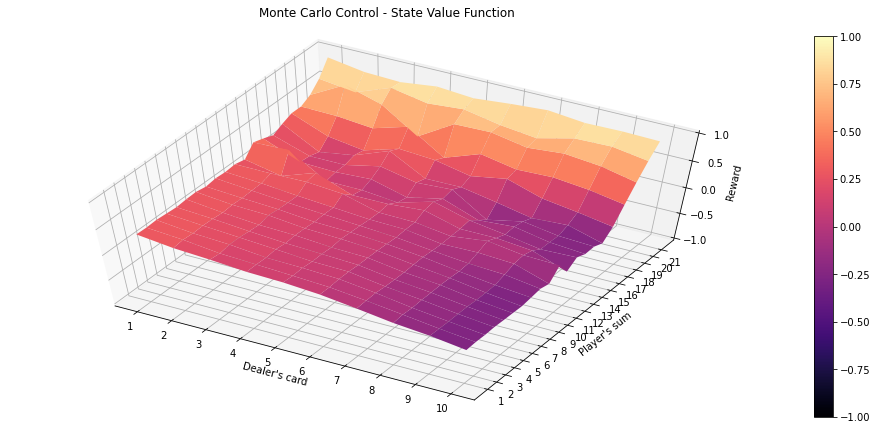

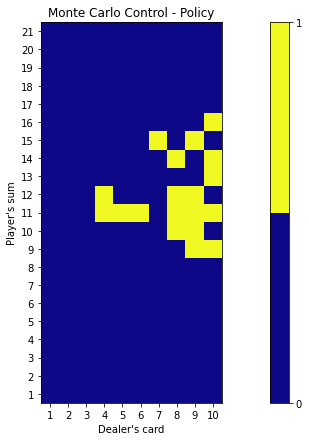

In [8]:
plot_values(Qmc.max(axis = 2), 'Monte Carlo Control - State Value Function') 
plot_policy(Qmc.argmax(axis = 2), 'Monte Carlo Control - Policy')

## 3. Sarsa($\lambda$)

In [9]:
def sarsa_lambda(env: Easy21, lambdaa: float, gamma: float = 1.0, episodes: int = int(1e3), Qopt: np.ndarray = None) -> Tuple[np.ndarray, List[float]]:
    N = np.zeros(state_action_dims(env), dtype = np.uint64)           # state-action visit counter
    Q = np.zeros_like(N, dtype = np.float64)                          # state-action values
    policy = lambda s: glie_eps_greedy_policy(env, s, Q, N, N0 = 100) # GLIE policy
    rmse = []

    for _ in tqdm(range(episodes)):
        E = np.zeros_like(N, dtype = np.float64)                      # eligibility traces

        # simulate step-by-step
        for st, at, rt_1, st_1, at_1, done in step_episode(env, policy):
            sa_pair = (*env.observation_space.unbias(st), at)
            E[sa_pair] += 1
            N[sa_pair] += 1   
            alpha = 1 / N[sa_pair]                                    # stepsize
            if done:
                delta = rt_1 - Q[sa_pair]
            else:
                sa_pair_1 = (*env.observation_space.unbias(st_1), at_1)
                delta = rt_1 + gamma * Q[sa_pair_1] - Q[sa_pair]      # TD error

            # update state-actions values and decay traces
            Q += alpha * delta * E
            E *= gamma * lambdaa

        if Qopt is not None: 
            rmse.append(compute_Q_rmse(env, Q, Qopt))
    return Q, rmse

In [ ]:
env = Easy21()
lambdas = np.arange(0, 1.1, 0.2)
Qs, rmses = list(zip(*[sarsa_lambda(env, lam, episodes = int(1e3), Qopt = Qmc) for lam in lambdas]))

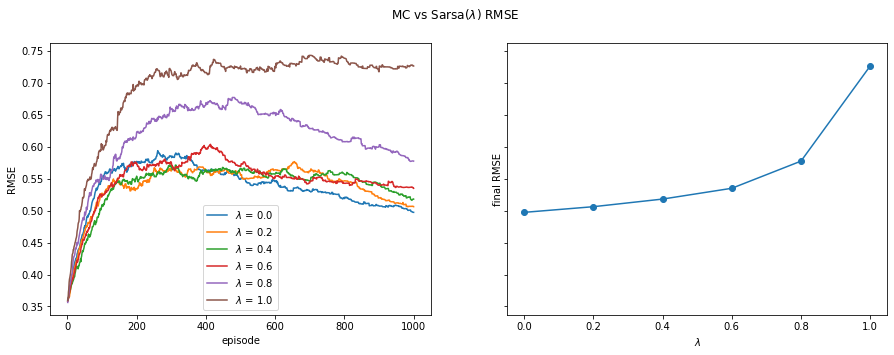

In [11]:
plot_rmses(lambdas, rmses, r'MC vs Sarsa($\lambda$) RMSE')

## 4. Sarsa($\lambda$) with Linear Function Approximation
Algorithm @ Sutton & Barto 12.7

In [12]:
def sarsa_lambda_linfnc_approx(env: Easy21, lambdaa: float, gamma: float = 1.0, episodes: int = int(1e3), Qopt: np.ndarray = None) -> Tuple[np.ndarray, np.ndarray, List[float]]:
    eps = 0.05                                                  # exploration rate
    alpha = 0.01                                                # stepsize
    w = np.zeros((6, 3, 2), dtype = np.float64)                 # linear function weights
    policy = lambda s: eps_greedy_linfnc_policy(env, s, w, eps) # eps-greedy policy
    rmse = []

    for _ in tqdm(range(episodes)):
        E = np.zeros_like(w)                                    # eligibility traces

        # simulate step-by-step
        for st, at, rt_1, st_1, at_1, done in step_episode(env, policy):
            E += get_features(st, at)
            delta = rt_1 - eval_q(st, at, w)                    # TD error
            if not done:
                delta += gamma * eval_q(st_1, at_1, w)
            
            # update weights and decay traces
            w += alpha * delta * E
            E *= gamma * lambdaa

        if Qopt is not None: 
            rmse.append(compute_Q_rmse(env, linfnc2tableQ(env, w), Qopt)) # not working
    return w, linfnc2tableQ(env, w), rmse

In [ ]:
env = Easy21()
lambdas = np.arange(0, 1.1, 0.2)
ws, Qs, rmses = list(zip(*[sarsa_lambda_linfnc_approx(env, lam, episodes = int(1e3), Qopt = Qmc) for lam in lambdas]))

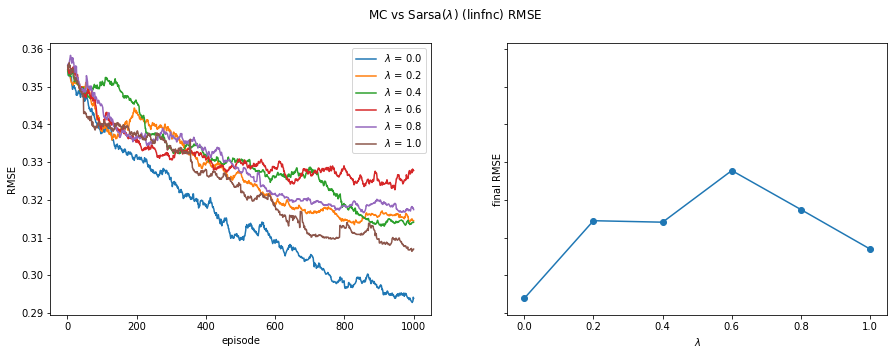

In [14]:
plot_rmses(lambdas, rmses, r'MC vs Sarsa($\lambda$) (linfnc) RMSE')